## Create MJO Index Feb

In [1]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import pandas as pd
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netCDF4
# from netCDF4 import *

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from scipy import interpolate
from scipy.interpolate import griddata
import time
import glob
import dask

from scipy.fftpack import fft
from scipy.fftpack import ifft
import copy
import eofs.standard as Eof_st
from matplotlib.colors import ListedColormap

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cmocean

## Useful Functions

In [2]:
#this functions pick data ranges out of an xarray data structure.
def is_dayofyear(dayofyear,dd):
    return (dayofyear==dd)

def is_dayofyear_range(dayofyear,dd1,dd2):
    
    if (dd2 > dd1) & (dd2<366) & (dd1>=1):
        return ((dayofyear>=dd1)&(dayofyear<=dd2))
    elif (dd2 > 366) & (dd1>0):
        dd2 = dd2 - 366
        print('you are wrapping around years... this is a warning if you arent intending to')
        return ((dayofyear>=dd1)|(dayofyear<=dd2))
    elif dd1 < 1:
        print('you are wrapping around years... this is a warning if you arent intending to')
        dd1 = dd1+366
        return ((dayofyear>=dd1)|(dayofyear<=dd2))
    else:
        print('this is an edge case you did not foresee')
        return np.nan
    
def cal_ano_dcli(var):
    '''return [var_ano, var_dcli], Taxis= axis of time'''
    var_dcli=var.groupby('time.dayofyear').mean(dim='time')
    var_ano= var - var.mean(dim = 'time')
    
    return var_ano, var_dcli

def is_doyrange(doy,dd,tod,hh):
    daywind = 45
    if (dd - daywind) < 1:
        # print('in 1')
        return ((doy >= (366+(dd-daywind))) | (doy <= dd+daywind)) & (tod==hh)
        
    elif (dd + daywind) > 366:
        # print('in 2')
        return ((((doy <= 366) & (doy>=(dd-daywind))) | (doy <= (-1*((366-(dd-daywind))-(2*daywind)))  )))&(tod==hh)
    
    else:
        # print('in 3')
        return ((doy >= dd-daywind) & (doy <= dd+daywind))&(tod==hh)


#make MJO base line months
def is_NDJFM(dayofyear):
    return ((dayofyear==11)|(dayofyear==12)|(dayofyear==1)|(dayofyear==2)|(dayofyear==3))

# def is_NDJFM(dayofyear):
#     return ((dayofyear==12)|(dayofyear==1)|(dayofyear==2))

# def is_NDJFM(dayofyear):
#     return ((dayofyear==1)|(dayofyear==2)|(dayofyear==3)|(dayofyear==4)|(dayofyear==5)|(dayofyear==6)|(dayofyear==7)|(dayofyear==8)|(dayofyear==9)|(dayofyear==10)|(dayofyear==11)|(dayofyear==12))

#  NDJFM_data = GPH_E20c.sel(time=is_NDJFM(GPH_E20c['time.month']))

## First Load the CESM LENS Data
need U850, U200, OLR (velocity potential)

#### Also Load V Wind--> 
This is just for plotting

In [14]:
FNSflut = sorted(glob.glob('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-esm-piControl.001/atm/proc/tseries/day_1/*FLUT.01*'))
DSFLUT = xr.open_mfdataset(FNSflut)
DSFLUT.to_netcdf("/glade/scratch/wchapman/data_for_KJM/FLUT_train.nc")

/glade/u/home/wchapman/.local/lib/python3.9/site-packages/xarray/conventions.py:232: SerializationWarning: variable date_written has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(
/glade/u/home/wchapman/.local/lib/python3.9/site-packages/xarray/conventions.py:232: SerializationWarning: variable time_written has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [6]:
%%time
DS200 = xr.open_mfdataset(sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/U200/*BHISTcmip6*.005.*')),combine='by_coords')

DS850 = xr.open_mfdataset(sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/U850/*BHISTcmip6*.005.*')),combine='by_coords')

DSFLUT = xr.open_mfdataset(sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/FLUT/*BHISTcmip6*.005.*')),combine='by_coords')

# Create the level coordinate
levels = [200, 850]
coord_lev = xr.DataArray(levels, dims='lev', attrs={'units': 'mb'})

DS200_U=DS200['U200']
DS850_U=DS850['U850']

# Add the level coordinate to each data array
DS200_U['lev'] = coord_lev.isel(lev=0)
DS850_U['lev'] = coord_lev.isel(lev=1)

# Combine U200 and U850 into a single dataset
fn_E20c_VP = xr.concat([DS200_U, DS850_U], dim='lev').to_dataset(name='u')
# Rename the 'lev' dimension to 'level'
latwant = [-15,15];
lev = [200,850] #m

DS_OLR=DSFLUT['FLUT'].to_dataset(name='ttr')

DS_MJOera5 = xr.merge([DS_OLR,fn_E20c_VP]).sel(lat =slice(latwant[0],latwant[1]))
DS_MJOera5 = DS_MJOera5.rename({'lat':'latitude','lon':'longitude','lev':'level'})
DS_MJOera5 = DS_MJOera5.sortby('latitude', ascending=False)
DS_MJOera5 = DS_MJOera5.transpose('time', 'level', 'latitude', 'longitude')
print('!!! think about adding V wind!!!')
DS_MJOera5=DS_MJOera5.convert_calendar("standard", use_cftime=True)
DS_MJOera5

!!! think about adding V wind!!!
CPU times: user 10.3 s, sys: 1.03 s, total: 11.4 s
Wall time: 45.8 s


<xarray.Dataset>
Dimensions:    (time: 60226, latitude: 32, longitude: 288, level: 2)
Coordinates:
  * latitude   (latitude) float64 14.61 13.66 12.72 ... -12.72 -13.66 -14.61
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * level      (level) int64 200 850
Data variables:
    ttr        (time, latitude, longitude) float32 dask.array<chunksize=(3650, 32, 288), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(3650, 1, 32, 288), meta=np.ndarray>

## Select your variables

In [7]:
DS_MJOera5 = DS_MJOera5.mean(['latitude']).squeeze() #zonal mean...
u200era20c = DS_MJOera5.sel(level=200).u
u850era20c = DS_MJOera5.sel(level=850).u
uOLRera20c = DS_MJOera5.ttr

## Calculate anomalies

In [8]:
[ERA20c_u200_1D_anom,ERA20c_u200_1D_dcli] = cal_ano_dcli(u200era20c)
[ERA20c_u850_1D_anom,ERA20c_u850_1D_dcli] = cal_ano_dcli(u850era20c)
[ERA20c_OLR_1D_anom,ERA20c_OLR_1D_dcli] = cal_ano_dcli(uOLRera20c)

## FFT 
Transform into frequency space to get the leading 3 harmonics

In [9]:
%%time
ERA20c_u200_1D_dcli_Freq = fft(ERA20c_u200_1D_dcli.values,axis=0)
print('fft1')
ERA20c_u850_1D_dcli_Freq = fft(ERA20c_u850_1D_dcli.values,axis=0)
print('fft2')
ERA20c_OLR_1D_dcli_Freq = fft(ERA20c_OLR_1D_dcli.values,axis=0)
print('fft3')

#number of harmonics
nhar=3+1

##### create Frequency space with only mean and first three harmonics (frequency)
# copy all frequency first
ERA20c_u200_1D_dcli_Freq_3AH=ERA20c_u200_1D_dcli_Freq.copy()
ERA20c_u850_1D_dcli_Freq_3AH=ERA20c_u850_1D_dcli_Freq.copy()
ERA20c_OLR_1D_dcli_Freq_3AH=ERA20c_OLR_1D_dcli_Freq.copy()

# only keep the first three freq (both complex conjugate!) and mean and set other coefficients as zeros
ERA20c_u200_1D_dcli_Freq_3AH[nhar:-1*nhar+1,:]=0
ERA20c_u850_1D_dcli_Freq_3AH[nhar:-1*nhar+1,:]=0
ERA20c_OLR_1D_dcli_Freq_3AH[nhar:-1*nhar+1,:]=0

## return the frequency to physical space and take the real part! 
ERA20c_u200_1D_dcli_3AH=np.real(ifft(ERA20c_u200_1D_dcli_Freq_3AH,axis=0))
ERA20c_u850_1D_dcli_3AH=np.real(ifft(ERA20c_u850_1D_dcli_Freq_3AH,axis=0))
ERA20c_OLR_1D_dcli_3AH=np.real(ifft(ERA20c_OLR_1D_dcli_Freq_3AH,axis=0))

fft1
fft2
fft3
CPU times: user 2min 26s, sys: 55.9 s, total: 3min 22s
Wall time: 3min 34s


## Test Plot Harmonics

this fucking takes too long
CPU times: user 4min 49s, sys: 1min 34s, total: 6min 23s
Wall time: 6min 38s


Text(0.5, 1.0, 'lon=62.5')

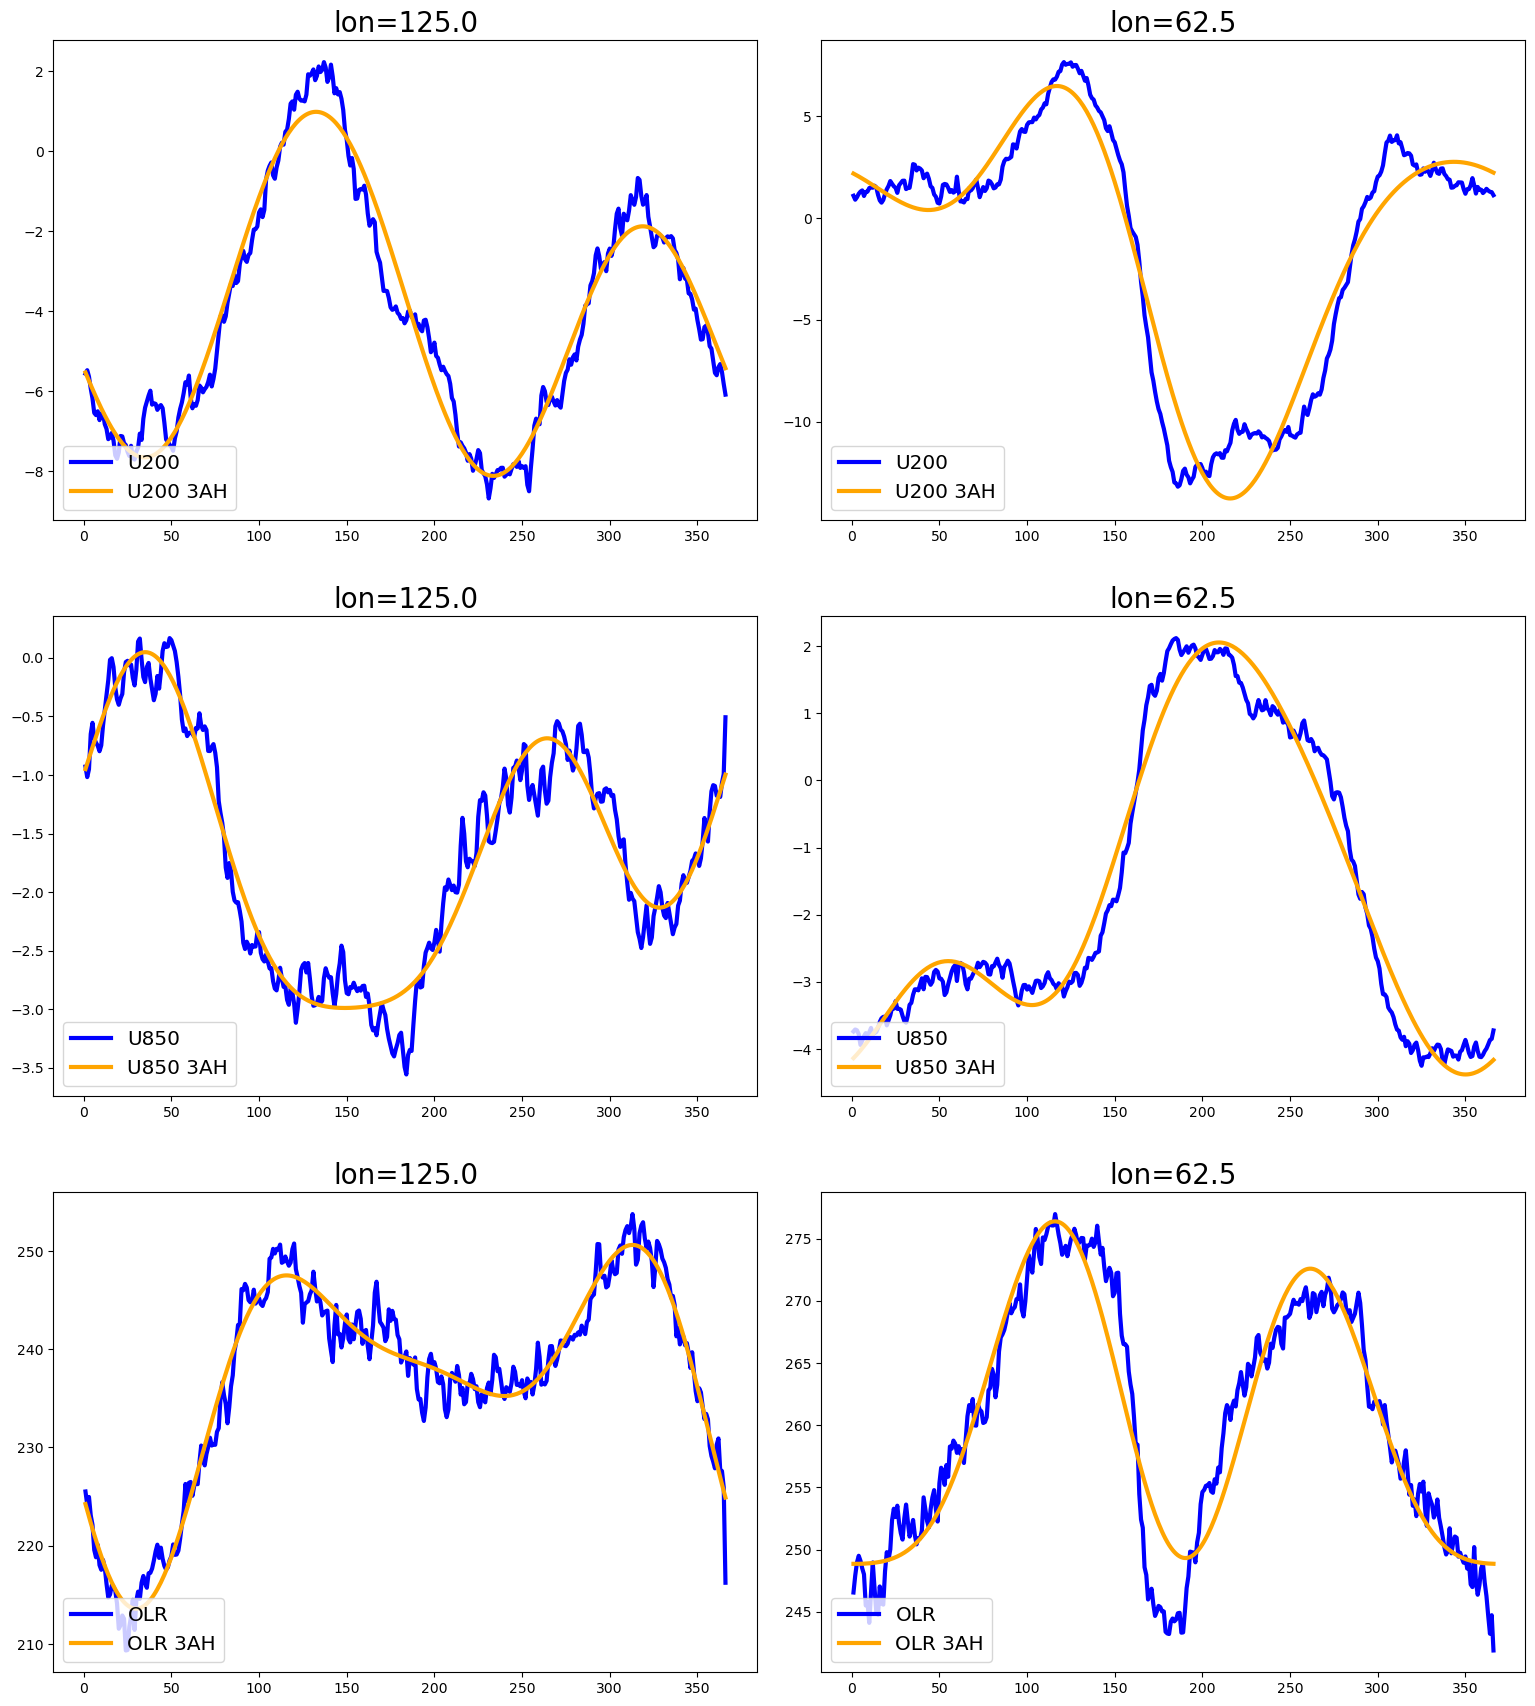

In [10]:
%%time
print('this fucking takes too long')
# ## ====== plot ====== the original and the data with first three harmonic 
fig=plt.figure()
ax1=fig.add_axes([0,0,1.1,1.])

NN=500
llon=100
Lwidth=3
plot1_2=ax1.plot(ERA20c_u200_1D_dcli.dayofyear,ERA20c_u200_1D_dcli[:,llon] 
                 ,color='blue',linewidth=Lwidth,label='U200')
plot1_3=ax1.plot(ERA20c_u200_1D_dcli.dayofyear,ERA20c_u200_1D_dcli_3AH[:,llon]
                 ,color='orange',linewidth=Lwidth,label='U200 3AH')

ax1.legend(loc='lower left',fontsize='x-large')
ax1.set_title('lon='+str(ERA20c_u200_1D_dcli.longitude.values[llon]),fontsize=20)

#########################
ax2=fig.add_axes([0,-1.2,1.1,1.])

# Lwidth=3
plot1_2=ax2.plot(ERA20c_u200_1D_dcli.dayofyear,ERA20c_u850_1D_dcli[:,llon] 
                 ,color='blue',linewidth=Lwidth,label='U850')
plot1_3=ax2.plot(ERA20c_u200_1D_dcli.dayofyear,ERA20c_u850_1D_dcli_3AH[:,llon]
                 ,color='orange',linewidth=Lwidth,label='U850 3AH')


ax2.legend(loc='lower left',fontsize='x-large')
ax2.set_title('lon='+str(ERA20c_u200_1D_dcli.longitude.values[llon]),fontsize=20)


#########################
ax3=fig.add_axes([0,-2.4,1.1,1.])

# Lwidth=3
plot1_2=ax3.plot(ERA20c_OLR_1D_dcli.dayofyear[:],ERA20c_OLR_1D_dcli[:,llon]  
                 ,color='blue',linewidth=Lwidth,label='OLR')
plot1_3=ax3.plot(ERA20c_OLR_1D_dcli.dayofyear,ERA20c_OLR_1D_dcli_3AH[:,llon]
                 ,color='orange',linewidth=Lwidth,label='OLR 3AH')


ax3.legend(loc='lower left',fontsize='x-large')

# # ax1.set_xlim(xmin,xmax)
# ax2.set_ylim(ymin,ymax)

# # ax1.set_yticks(np.arange(ymin,ymax+1))
# # ax1.set_yticklabels(np.arange(ymin,ymax+1),fontsize=15)
ax3.set_title('lon='+str(ERA20c_OLR_1D_dcli.longitude.values[llon]),fontsize=20)

#########################
ax4=fig.add_axes([1.2,0,1.1,1.])
llon=50

plot1_2=ax4.plot(ERA20c_u200_1D_dcli.dayofyear,ERA20c_u200_1D_dcli[:,llon] 
                 ,color='blue',linewidth=Lwidth,label='U200')
plot1_3=ax4.plot(ERA20c_u200_1D_dcli.dayofyear,ERA20c_u200_1D_dcli_3AH[:,llon]
                 ,color='orange',linewidth=Lwidth,label='U200 3AH')

ax4.legend(loc='lower left',fontsize='x-large')

ax4.set_title('lon='+str(ERA20c_u200_1D_dcli.longitude.values[llon]),fontsize=20)

#########################
ax4=fig.add_axes([1.2,-1.2,1.1,1.])

plot1_2=ax4.plot(ERA20c_u200_1D_dcli.dayofyear,ERA20c_u850_1D_dcli[:,llon] 
                 ,color='blue',linewidth=Lwidth,label='U850')
plot1_3=ax4.plot(ERA20c_u200_1D_dcli.dayofyear,ERA20c_u850_1D_dcli_3AH[:,llon]
                 ,color='orange',linewidth=Lwidth,label='U850 3AH')


ax4.legend(loc='lower left',fontsize='x-large')

ax4.set_title('lon='+str(ERA20c_u200_1D_dcli.longitude.values[llon]),fontsize=20)


#########################
ax6=fig.add_axes([1.2,-2.4,1.1,1.])

plot1_2=ax6.plot(ERA20c_OLR_1D_dcli.dayofyear[:],ERA20c_OLR_1D_dcli[:,llon] 
                 ,color='blue',linewidth=Lwidth,label='OLR')
plot1_3=ax6.plot(ERA20c_OLR_1D_dcli.dayofyear,ERA20c_OLR_1D_dcli_3AH[:,llon]
                 ,color='orange',linewidth=Lwidth,label='OLR 3AH')

ax6.legend(loc='lower left',fontsize='x-large')
ax6.set_title('lon='+str(ERA20c_OLR_1D_dcli.longitude.values[llon]),fontsize=20)


In [11]:
## copy the data structure of the daily climatology for the daily climatology with only first three annual harmonics
da_ERA20c_u200_1D_dcli_3AH=ERA20c_u200_1D_dcli.copy()*np.nan
da_ERA20c_u850_1D_dcli_3AH=ERA20c_u850_1D_dcli.copy()*np.nan
da_ERA20c_OLR_1D_dcli_3AH = ERA20c_OLR_1D_dcli.copy()*np.nan
## specify the values 
da_ERA20c_u200_1D_dcli_3AH.values=ERA20c_u200_1D_dcli_3AH
da_ERA20c_u850_1D_dcli_3AH.values=ERA20c_u850_1D_dcli_3AH
da_ERA20c_OLR_1D_dcli_3AH.values =ERA20c_OLR_1D_dcli_3AH

## Anomalies remove climo with only first three harmonics

In [12]:
### calculate ANOMALY: remove daily climatology with only first three annual harmonics
da_ERA20c_u200_1D_ANOrm3AH = u200era20c.groupby('time.dayofyear')-da_ERA20c_u200_1D_dcli_3AH
da_ERA20c_u850_1D_ANOrm3AH = u850era20c.groupby('time.dayofyear')-da_ERA20c_u850_1D_dcli_3AH
da_ERA20c_OLR_1D_ANOrm3AH  = uOLRera20c.groupby('time.dayofyear')-da_ERA20c_OLR_1D_dcli_3AH

## subtract 120 days average before the values 


## Finally we need to load the arrays

In [13]:
%%time
da_ERA20c_OLR_1D_ANOrm3AH = da_ERA20c_OLR_1D_ANOrm3AH.load()
print('...OLR loaded...')
da_ERA20c_u200_1D_ANOrm3AH=da_ERA20c_u200_1D_ANOrm3AH.load()
print('...u200 loaded...')
da_ERA20c_u850_1D_ANOrm3AH=da_ERA20c_u850_1D_ANOrm3AH.load()
print('...u850 loaded...')


...OLR loaded...
...u200 loaded...
...u850 loaded...
CPU times: user 2min 25s, sys: 50.2 s, total: 3min 15s
Wall time: 3min 25s


In [14]:
%%time
#filter the arrays
AvgdayN=120

da_ERA20c_OLR_1D_ANOrm3AH_filtered= np.array(da_ERA20c_OLR_1D_ANOrm3AH[:,:]*np.nan)
da_ERA20c_u200_1D_ANOrm3AH_filtered= np.array(da_ERA20c_u200_1D_ANOrm3AH[:,:]*np.nan)
da_ERA20c_u850_1D_ANOrm3AH_filtered= np.array(da_ERA20c_u850_1D_ANOrm3AH[:,:]*np.nan)


tmp_olr = np.array(da_ERA20c_OLR_1D_ANOrm3AH[:,:])
tmp_u200 = np.array(da_ERA20c_u200_1D_ANOrm3AH[:,:])
tmp_u850 = np.array(da_ERA20c_u850_1D_ANOrm3AH[:,:])


# first_date = da_ERA20c_OLR_1D_ANOrm3AH.time.values[0]
# first_date_120 = da_ERA20c_OLR_1D_ANOrm3AH.time.values[0] + np.timedelta64(AvgdayN-1, 'D') 
# had to do this stupid: 
first_date = 0
first_date_120 = 120

print('entering loop')
for cnt,tata in enumerate(da_ERA20c_OLR_1D_ANOrm3AH.time.values[:]):
    
    if cnt%1000 == 0: 
        print('iteration: ', cnt, ' of', da_ERA20c_OLR_1D_ANOrm3AH.time.values.shape[0])
#     print(tata)
#     minus120 = tata - np.timedelta64(AvgdayN-1, 'D')
    minus120 = cnt - 120
#     print(minus120)
    
    if first_date > minus120: 
        print('in here:',tata,'count: ',cnt)
        
        u200_120m = da_ERA20c_u200_1D_ANOrm3AH.isel(time=slice(first_date,first_date_120)).mean(dim='time')
        u850_120m = da_ERA20c_u850_1D_ANOrm3AH.isel(time=slice(first_date,first_date_120)).mean(dim='time')
        OLR_120m = da_ERA20c_OLR_1D_ANOrm3AH.isel(time=slice(first_date,first_date_120)).mean(dim='time')
    else: 
        u200_120m = da_ERA20c_u200_1D_ANOrm3AH.isel(time=slice(minus120,cnt)).mean(dim='time')
        u850_120m = da_ERA20c_u850_1D_ANOrm3AH.isel(time=slice(minus120,cnt)).mean(dim='time')
        OLR_120m = da_ERA20c_OLR_1D_ANOrm3AH.isel(time=slice(minus120,cnt)).mean(dim='time')

        
        
    da_ERA20c_OLR_1D_ANOrm3AH_filtered[cnt] = tmp_olr[cnt]-np.array(OLR_120m)
    da_ERA20c_u200_1D_ANOrm3AH_filtered[cnt] = tmp_u200[cnt]-np.array(u200_120m)
    da_ERA20c_u850_1D_ANOrm3AH_filtered[cnt] = tmp_u850[cnt]-np.array(u850_120m)
    
print('done')
    
da_ERA20c_OLR_1D_ANOrm3AH_filtered = xr.Dataset(
    {
        "ttr": (["time", "longitude"],da_ERA20c_OLR_1D_ANOrm3AH_filtered),    
    },
    coords={

        "longitude":da_ERA20c_OLR_1D_ANOrm3AH.longitude,
        "time":da_ERA20c_OLR_1D_ANOrm3AH.time,
    },)



da_ERA20c_u200_1D_ANOrm3AH_filtered = xr.Dataset(
    {
        "u": (["time", "longitude"],da_ERA20c_u200_1D_ANOrm3AH_filtered),    
    },
    coords={

        "longitude":da_ERA20c_u200_1D_ANOrm3AH.longitude,
        "time":da_ERA20c_u200_1D_ANOrm3AH.time,
    },)

da_ERA20c_u850_1D_ANOrm3AH_filtered = xr.Dataset(
    {
        "u": (["time", "longitude"],da_ERA20c_u850_1D_ANOrm3AH_filtered),    
    },
    coords={

        "longitude":da_ERA20c_u850_1D_ANOrm3AH.longitude,
        "time":da_ERA20c_u850_1D_ANOrm3AH.time,
    },)

entering loop
iteration:  0  of 60226
in here: 1850-01-01 00:00:00 count:  0
in here: 1850-01-02 00:00:00 count:  1
in here: 1850-01-03 00:00:00 count:  2
in here: 1850-01-04 00:00:00 count:  3
in here: 1850-01-05 00:00:00 count:  4
in here: 1850-01-06 00:00:00 count:  5
in here: 1850-01-07 00:00:00 count:  6
in here: 1850-01-08 00:00:00 count:  7
in here: 1850-01-09 00:00:00 count:  8
in here: 1850-01-10 00:00:00 count:  9
in here: 1850-01-11 00:00:00 count:  10
in here: 1850-01-12 00:00:00 count:  11
in here: 1850-01-13 00:00:00 count:  12
in here: 1850-01-14 00:00:00 count:  13
in here: 1850-01-15 00:00:00 count:  14
in here: 1850-01-16 00:00:00 count:  15
in here: 1850-01-17 00:00:00 count:  16
in here: 1850-01-18 00:00:00 count:  17
in here: 1850-01-19 00:00:00 count:  18
in here: 1850-01-20 00:00:00 count:  19
in here: 1850-01-21 00:00:00 count:  20
in here: 1850-01-22 00:00:00 count:  21
in here: 1850-01-23 00:00:00 count:  22
in here: 1850-01-24 00:00:00 count:  23
in here: 185

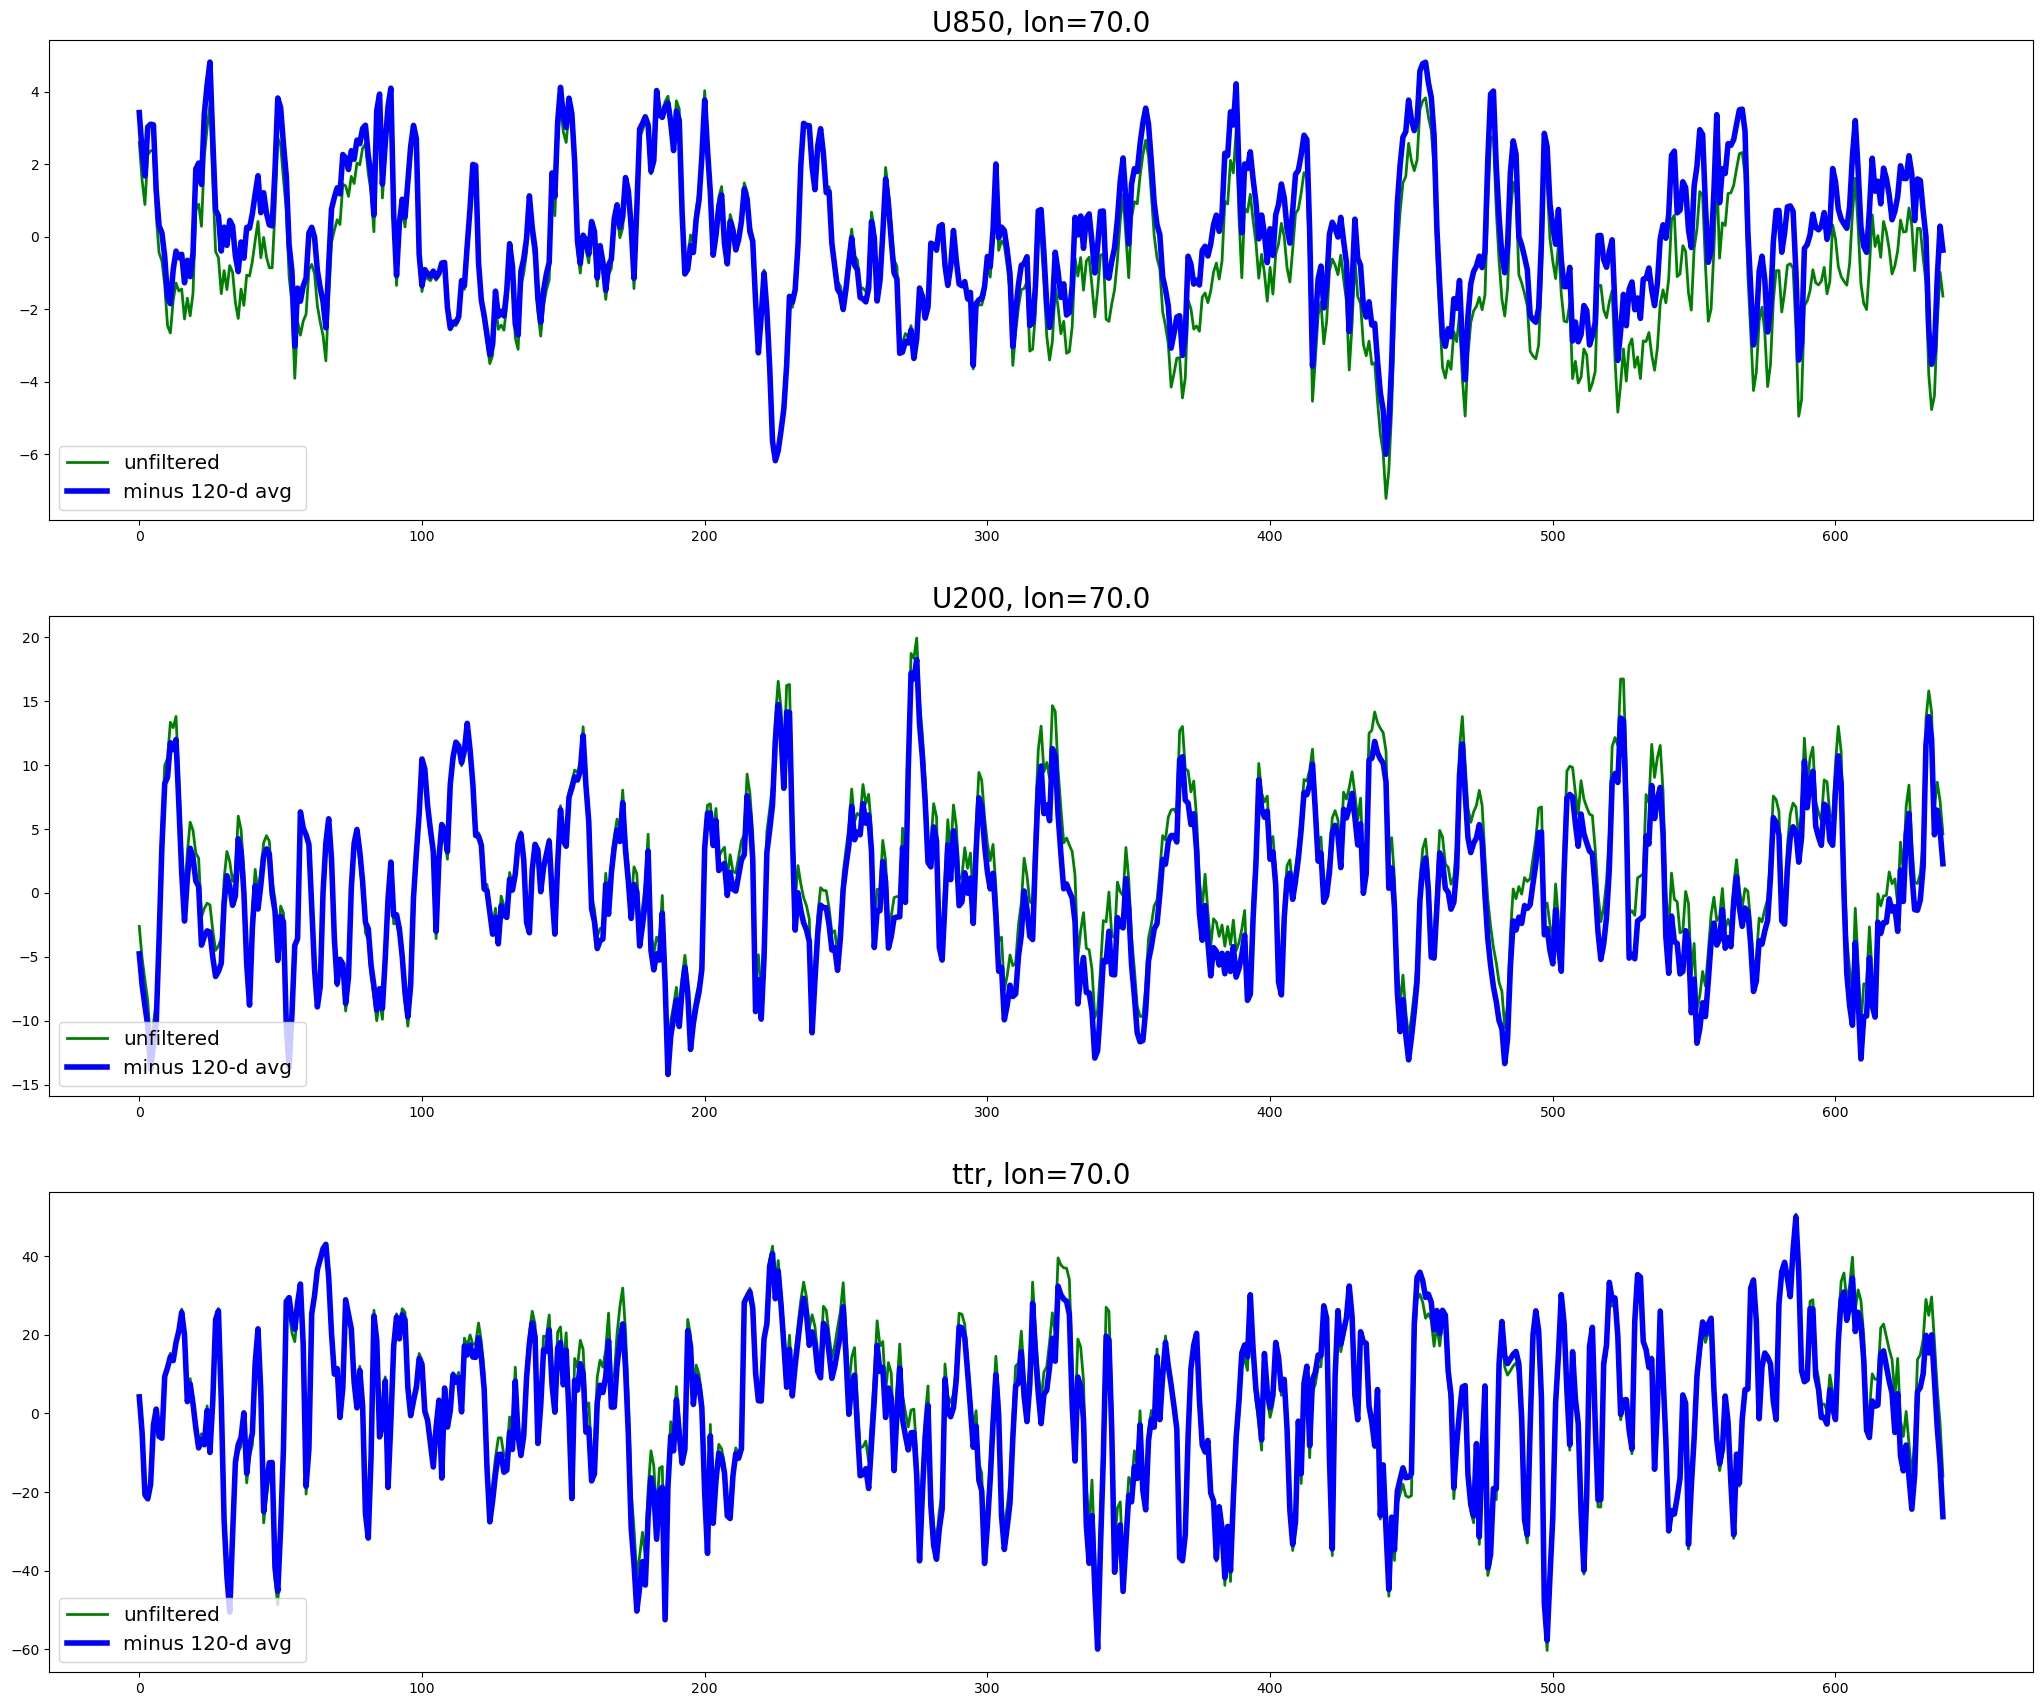

In [15]:
# ## ====== plot ======

ymin=-25
ymax=25
fig=plt.figure()
ax1=fig.add_axes([0,0,3.1,1.])

llon=56
tt1_ori=366-6
tt2_ori=1000-1


time_period=da_ERA20c_u850_1D_ANOrm3AH.time[tt1_ori:tt2_ori]
lon_values=da_ERA20c_u850_1D_ANOrm3AH.longitude.values[llon]

plot1_1=ax1.plot(np.arange(len(time_period)),da_ERA20c_u850_1D_ANOrm3AH[tt1_ori:tt2_ori,llon],color='green',linewidth=Lwidth-1,label='unfiltered')
plot1_2=ax1.plot(np.arange(len(time_period)),da_ERA20c_u850_1D_ANOrm3AH_filtered.u[tt1_ori:tt2_ori,llon],color='blue',linewidth=Lwidth+1,label='minus 120-d avg ')

ax1.legend(loc='lower left',fontsize='x-large')
ax1.set_title('U850, lon='+str(lon_values)+'',fontsize=20)


ax2=fig.add_axes([0,-1.2,3.1,1.])
plot2_1=ax2.plot(np.arange(len(time_period)),da_ERA20c_u200_1D_ANOrm3AH[tt1_ori:tt2_ori,llon],color='green',linewidth=Lwidth-1,label='unfiltered')
plot2_2=ax2.plot(np.arange(len(time_period)),da_ERA20c_u200_1D_ANOrm3AH_filtered.u[tt1_ori:tt2_ori,llon],color='blue',linewidth=Lwidth+1,label='minus 120-d avg ')

ax2.legend(loc='lower left',fontsize='x-large')
ax2.set_title('U200, lon='+str(lon_values)+'',fontsize=20)

ax3=fig.add_axes([0,-2.4,3.1,1.])
plot3_1=ax3.plot(np.arange(len(time_period)),da_ERA20c_OLR_1D_ANOrm3AH[tt1_ori:tt2_ori,llon],color='green',linewidth=Lwidth-1,label='unfiltered')
plot3_2=ax3.plot(np.arange(len(time_period)),da_ERA20c_OLR_1D_ANOrm3AH_filtered.ttr[tt1_ori:tt2_ori,llon],color='blue',linewidth=Lwidth+1,label='minus 120-d avg ')

ax3.legend(loc='lower left',fontsize='x-large')
ax3.set_title('ttr, lon='+str(lon_values)+'',fontsize=20)
plt.show()

## Normalize the Time Series

## Select NDJFM

In [16]:

# NDJFM_data = GPH_E20c.sel(time=is_NDJFM(GPH_E20c['time.month']))
NDJFM_data_OLR = copy.deepcopy(da_ERA20c_OLR_1D_ANOrm3AH_filtered.sel(time=is_NDJFM(da_ERA20c_OLR_1D_ANOrm3AH_filtered['time.month'])))
NDJFM_data_u200 = copy.deepcopy(da_ERA20c_u200_1D_ANOrm3AH_filtered.sel(time=is_NDJFM(da_ERA20c_u200_1D_ANOrm3AH_filtered['time.month'])))
NDJFM_data_u850 = copy.deepcopy(da_ERA20c_u850_1D_ANOrm3AH_filtered.sel(time=is_NDJFM(da_ERA20c_u850_1D_ANOrm3AH_filtered['time.month'])))


NDJFM_data_OLR = copy.deepcopy(da_ERA20c_OLR_1D_ANOrm3AH_filtered)
NDJFM_data_u200 = copy.deepcopy(da_ERA20c_u200_1D_ANOrm3AH_filtered)
NDJFM_data_u850 = copy.deepcopy(da_ERA20c_u850_1D_ANOrm3AH_filtered)


In [17]:
#### compute temporal variance at each lon and take longitudinal mean
NDJFM_data_OLR_Zavg=NDJFM_data_OLR.var(dim='time').mean(dim='longitude')
NDJFM_data_u200_Zavg=NDJFM_data_u200.var(dim='time').mean(dim='longitude')
NDJFM_data_u850_Zavg=NDJFM_data_u850.var(dim='time').mean(dim='longitude')


ERA20c_OLR_Zavg = (np.sqrt(NDJFM_data_OLR_Zavg))
ERA20c_u200_Zavg = (np.sqrt(NDJFM_data_u200_Zavg))
ERA20c_u850_Zavg = (np.sqrt(NDJFM_data_u850_Zavg))

print(np.sqrt(NDJFM_data_OLR_Zavg))
print(np.sqrt(NDJFM_data_u200_Zavg))
print(np.sqrt(NDJFM_data_u850_Zavg))

NDJFM_data_OLR_normalized = NDJFM_data_OLR/np.sqrt(NDJFM_data_OLR_Zavg)

NDJFM_data_u200_normalized = NDJFM_data_u200/np.sqrt(NDJFM_data_u200_Zavg)

NDJFM_data_u850_normalized = NDJFM_data_u850/np.sqrt(NDJFM_data_u850_Zavg)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    ttr      float32 19.91
<xarray.Dataset>
Dimensions:  ()
Data variables:
    u        float32 6.187
<xarray.Dataset>
Dimensions:  ()
Data variables:
    u        float32 2.255


## EOF basis Functions 
do a multi-variable eof... olr u200 u850.

In [18]:
#************************************************
# Combine the normalized data into one variable
nlon=NDJFM_data_OLR_normalized.longitude.shape[0]
ntime_trim=NDJFM_data_OLR_normalized.time.shape[0]

cdata_trim=np.zeros((ntime_trim,3*nlon))
cdata_trim[:,0:nlon]=NDJFM_data_OLR_normalized.to_array().squeeze()      # olr
cdata_trim[:,nlon:2*nlon]=NDJFM_data_u850_normalized.to_array().squeeze()      # u850
cdata_trim[:,2*nlon:3*nlon]=NDJFM_data_u200_normalized.to_array().squeeze()        # u200

In [19]:
neof = 2

solver_trim=Eof_st.Eof(cdata_trim)
# calculate eof and PCs
eof_cdata_trim=solver_trim.eofs(neofs=neof,eofscaling=2)
eof_ts_cdata_trim= solver_trim.pcs(npcs=2,pcscaling=1) #PCs are scaled to unit variance (divided by the square-root of their eigenvalue).

print(solver_trim.varianceFraction(neigs=3))

[0.12109525 0.11422245 0.06488863]


In [20]:
nvar = 3  # "olr", "u850", "u200"
ceof_trim = np.zeros((nvar,neof,nlon))

for n in range(0,neof):
    ceof_trim[0,n,:] = eof_cdata_trim[n,0:nlon]      # olr
    ceof_trim[1,n,:] = eof_cdata_trim[n,nlon:2*nlon]     # u850
    ceof_trim[2,n,:] = eof_cdata_trim[n,2*nlon:3*nlon]       # u200
np.savez('/glade/work/wchapman/For_Tony/MJO_CESMBHIST.npz', ceof_trim=ceof_trim)


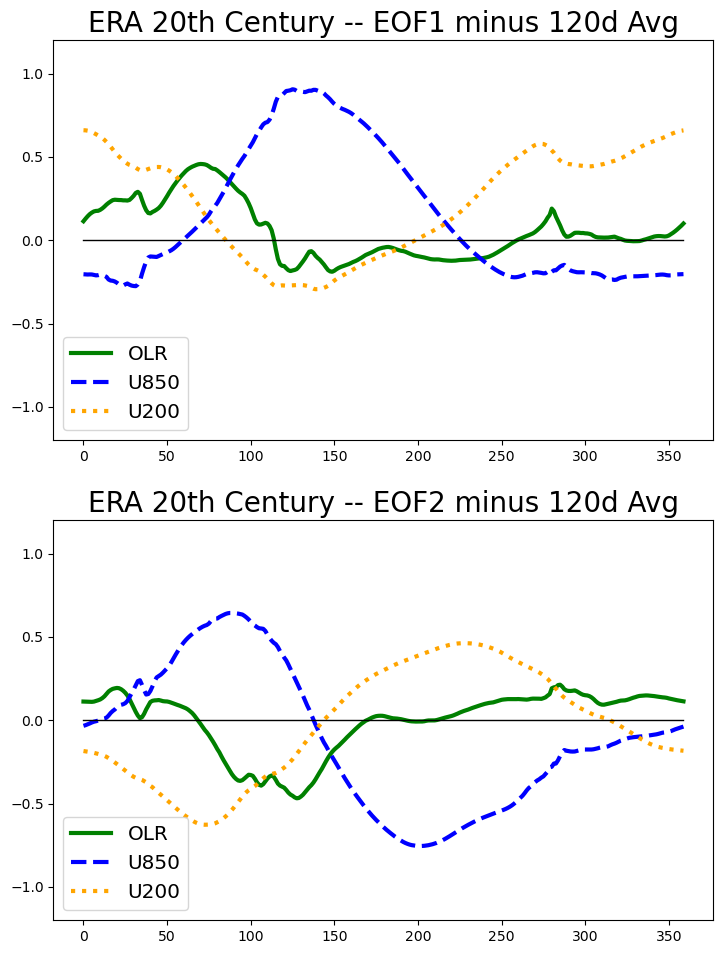

In [27]:

# ## ====== plot ======

ymin=-1.2
ymax=1.2

fig=plt.figure(figsize=(6,4))
ax1=fig.add_axes([0,0,1.1,1.])

NN=500
Lwidth=3

lon=NDJFM_data_u850_normalized.longitude

plot1_1=ax1.plot(lon,ceof_trim[0,0,:]
                 ,color='green',linewidth=Lwidth,label='OLR')
plot1_2=ax1.plot(lon,ceof_trim[1,0,:]
                 ,color='blue',linewidth=Lwidth,linestyle='--',label='U850')
plot1_3=ax1.plot(lon,ceof_trim[2,0,:]
                 ,color='orange',linewidth=Lwidth,linestyle=':',label='U200')


plot1_4=ax1.plot(lon,ceof_trim[2,0,:]*0
                 ,color='black',linewidth=Lwidth-2,label='')


ax1.legend(loc='lower left',fontsize='x-large')

# ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

# ax1.set_yticks(np.arange(ymin,ymax+1))
# ax1.set_yticklabels(np.arange(ymin,ymax+1),fontsize=15)
ax1.set_title('ERA 20th Century -- EOF1 minus 120d Avg',fontsize=20)

#########################################
#########################################

ax2=fig.add_axes([0,-1.2,1.1,1.])

NN=500
Lwidth=3
plot1_1=ax2.plot(lon,-ceof_trim[0,1,:]
                 ,color='green',linewidth=Lwidth,label='OLR')
plot1_2=ax2.plot(lon,-ceof_trim[1,1,:]
                 ,color='blue',linewidth=Lwidth,linestyle='--',label='U850')
plot1_3=ax2.plot(lon,-ceof_trim[2,1,:]
                 ,color='orange',linewidth=Lwidth,linestyle=':',label='U200')


plot1_4=ax2.plot(lon,ceof_trim[2,1,:]*0
                 ,color='black',linewidth=Lwidth-2,label='')


ax2.legend(loc='lower left',fontsize='x-large')
ax2.set_ylim(ymin,ymax)
ax2.set_title('ERA 20th Century -- EOF2 minus 120d Avg',fontsize=20)
plt.show()

## Save a Full RMM1 and RMM2 index dataset
need to project the modes onto the full dataset

In [28]:
da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized = da_ERA20c_OLR_1D_ANOrm3AH_filtered/np.sqrt(NDJFM_data_OLR_Zavg)
da_ERA20c_u200_1D_ANOrm3AH_filtered_normalized = da_ERA20c_u200_1D_ANOrm3AH_filtered/np.sqrt(NDJFM_data_u200_Zavg)
da_ERA20c_u850_1D_ANOrm3AH_filtered_normalized = da_ERA20c_u850_1D_ANOrm3AH_filtered/np.sqrt(NDJFM_data_u850_Zavg)


#************************************************
# Combine the normalized data into one variable
nlon=da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.longitude.shape[0]
ntime_trim=da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.time.shape[0]

cdata_trim=np.zeros((ntime_trim,3*nlon))
cdata_trim[:,0:nlon]=da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.to_array().squeeze()      # olr
cdata_trim[:,nlon:2*nlon]=da_ERA20c_u850_1D_ANOrm3AH_filtered_normalized.to_array().squeeze()      # u850
cdata_trim[:,2*nlon:3*nlon]=da_ERA20c_u200_1D_ANOrm3AH_filtered_normalized.to_array().squeeze()        # u200
neof=2
pj_sub=solver_trim.projectField(cdata_trim,neofs=neof,eofscaling=1)

RMM1_obs = -pj_sub[:,1] 
RMM2_obs = pj_sub[:,0] ### I think this is right

## Phase and Index

In [29]:
%%time
#we do the MJO phase calculation here:
MJO_phase = []
RMMind = np.sqrt(RMM1_obs**2 + RMM2_obs**2) # full index

for ii in range(RMMind.shape[0]):    
    if np.isnan(RMMind[ii]):
        MJO_phase.append(np.nan)
    elif RMMind[ii] < 1:
        MJO_phase.append(0)
    else:
        ang = np.degrees(np.arctan2(RMM2_obs[ii],RMM1_obs[ii]))
        if ang<0:
            ang = ang+360
        ang = ang+180 

        if ang > 360:
            ang=ang-360
            
        MJO_phase.append(np.floor((ang)/45)+1)
        
        
MJO_phase = np.array(MJO_phase)

CPU times: user 170 ms, sys: 1.95 ms, total: 172 ms
Wall time: 174 ms


## Save the Dataset

In [30]:
MJO_fobs = xr.Dataset(
    {
        "RMM1_era20c": (["time"],RMM1_obs.data),
        "RMM2_era20c": (["time"],RMM2_obs.data),
        "RMMind_era20c": (["time"],RMMind.data),
        "RMMphase_era20c": (["time"],MJO_phase),
        "olr_norm":(["time","longitude"],da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.ttr.data), 
        "eof1_olr":(["longitude"],ceof_trim[0,0,:]),
        "eof2_olr":(["longitude"],ceof_trim[0,1,:]),
        "eof1_u850":(["longitude"],ceof_trim[1,0,:]),
        "eof2_u850":(["longitude"],ceof_trim[1,1,:]),
        "eof1_u200":(["longitude"],ceof_trim[2,0,:]),
        "eof2_u200":(["longitude"],ceof_trim[2,1,:]),
        "u200_norm":(["time","longitude"],da_ERA20c_u200_1D_ANOrm3AH_filtered_normalized.u.data), 
        "u850_norm":(["time","longitude"],da_ERA20c_u850_1D_ANOrm3AH_filtered_normalized.u.data), 
    },
    coords={
        "time":da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.time,
        "longitude":da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.longitude,
    },)


MJO_fobs.attrs["title"] = "CESM MJO RMM Forecast eof(u850,u200,olr)"
MJO_fobs.attrs["description"] = "MJO obs in the CESM member dataset calculated as in Wheeler and Hendon 2004, a 120-day filter, 15S-15N averaged variables "

MJO_fobs.RMM1_era20c.attrs['units'] = 'stddev'
MJO_fobs.RMM1_era20c.attrs['standard_name']='RMM1'
MJO_fobs.RMM1_era20c.attrs['long_name']='RMM1'

MJO_fobs.RMM2_era20c.attrs['units'] = 'stddev'
MJO_fobs.RMM2_era20c.attrs['standard_name']='RMM2'
MJO_fobs.RMM2_era20c.attrs['long_name']='RMM2'

MJO_fobs.olr_norm.attrs['units'] = 'stddev'
MJO_fobs.olr_norm.attrs['standard_name']='outgoing longwave - normalized'
MJO_fobs.olr_norm.attrs['long_name']='outgoing longwave - normalized'


MJO_fobs.u200_norm.attrs['units'] = 'stddev'
MJO_fobs.u200_norm.attrs['standard_name']='u200 normalized'
MJO_fobs.u200_norm.attrs['long_name']='u200 normalized'

MJO_fobs.u850_norm.attrs['units'] = 'stddev'
MJO_fobs.u850_norm.attrs['standard_name']='u200 normalized'
MJO_fobs.u850_norm.attrs['long_name']='u200 normalized'

svname = '/glade/work/wchapman/For_Tony/'+'MJO_CESM2_BHIST_OLR_obs_1850_2015.nc'
MJO_fobs.to_netcdf(svname)
mean_obs_RMM1 = np.mean(RMM1_obs)
mean_obs_RMM2 = np.mean(RMM2_obs)
std_obs_RMM1 = np.std(RMM1_obs)
std_obs_RMM2 = np.std(RMM2_obs)

## Test against BOM index

## Composite VP by Phase

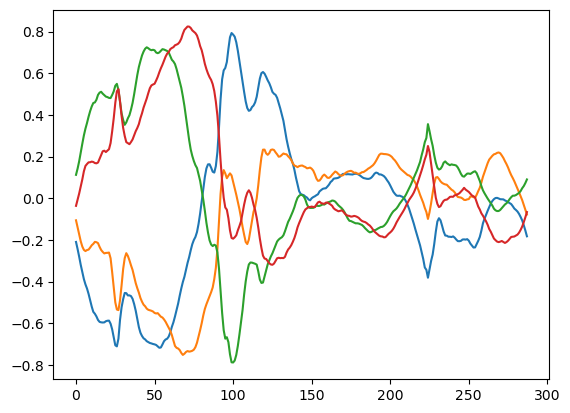

In [31]:
NDJFM_mjo = copy.deepcopy(MJO_fobs.sel(time=is_NDJFM(MJO_fobs['time.month'])))
# plt.plot((NDJFM_mjo.olr_norm.where((NDJFM_mjo.RMMind_era20c>1) & (NDJFM_mjo.RMMphase_era20c==1))).mean('time'))
plt.plot((NDJFM_mjo.olr_norm.where((NDJFM_mjo.RMMind_era20c>1) & (NDJFM_mjo.RMMphase_era20c==2))).mean('time'))
plt.plot((NDJFM_mjo.olr_norm.where((NDJFM_mjo.RMMind_era20c>1) & (NDJFM_mjo.RMMphase_era20c==3))).mean('time'))
# plt.plot((NDJFM_mjo.olr_norm.where((NDJFM_mjo.RMMind_era20c>1) & (NDJFM_mjo.RMMphase_era20c==4))).mean('time'))
# plt.plot((NDJFM_mjo.olr_norm.where((NDJFM_mjo.RMMind_era20c>1) & (NDJFM_mjo.RMMphase_era20c==5))).mean('time'))
plt.plot((NDJFM_mjo.olr_norm.where((NDJFM_mjo.RMMind_era20c>1) & (NDJFM_mjo.RMMphase_era20c==6))).mean('time'))
plt.plot((NDJFM_mjo.olr_norm.where((NDJFM_mjo.RMMind_era20c>1) & (NDJFM_mjo.RMMphase_era20c==7))).mean('time'))
# plt.plot((NDJFM_mjo.olr_norm.where((NDJFM_mjo.RMMind_era20c>1) & (NDJFM_mjo.RMMphase_era20c==8))).mean('time'))
plt.show()

## Create Full projection 

In [32]:
DS200 = xr.open_mfdataset(sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/U200/*BHISTcmip6*.005.*')),combine='by_coords')

DS850 = xr.open_mfdataset(sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/U850/*BHISTcmip6*.005.*')),combine='by_coords')

DSFLUT = xr.open_mfdataset(sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/FLUT/*BHISTcmip6*.005.*')),combine='by_coords')

# Create the level coordinate
levels = [200, 850]
coord_lev = xr.DataArray(levels, dims='lev', attrs={'units': 'mb'})

DS200_U=DS200['U200']
DS850_U=DS850['U850']

# Add the level coordinate to each data array
DS200_U['lev'] = coord_lev.isel(lev=0)
DS850_U['lev'] = coord_lev.isel(lev=1)

# Combine U200 and U850 into a single dataset
fn_E20c_VP = xr.concat([DS200_U, DS850_U], dim='lev').to_dataset(name='u')
# Rename the 'lev' dimension to 'level'
latwant = [-15,15];
lev = [200,850] #m

DS_OLR=DSFLUT['FLUT'].to_dataset(name='ttr')

DS_MJOera5 = xr.merge([DS_OLR,fn_E20c_VP]).sel(lat =slice(latwant[0],latwant[1]))
DS_MJOera5 = DS_MJOera5.rename({'lat':'latitude','lon':'longitude','lev':'level'})
DS_MJOera5 = DS_MJOera5.sortby('latitude', ascending=False)
DS_MJOera5 = DS_MJOera5.transpose('time', 'level', 'latitude', 'longitude')
print('!!! think about adding V wind!!!')
DS_MJOera5 = DS_MJOera5.mean(['latitude']).squeeze()
print('...loading...')
DS_MJOera5=DS_MJOera5.load()

!!! think about adding V wind!!!
...loading...


In [33]:
%%time
# DS_MJOera5 = xr.open_dataset('/glade/scratch/wchapman/ERA20c/MJO_CERA/PreProcessed_CERA_MJO_Variables.nc')
DS_MJOera5
print('dataset opened...')
# DS_MJOera5 = DS_MJOera5.mean('latitude')
u200era20c = DS_MJOera5.sel(level=200).u
u850era20c = DS_MJOera5.sel(level=850).u
uOLRera20c = DS_MJOera5.ttr

print('climos..')
[ERA20c_u200_1D_anom,ERA20c_u200_1D_dcli] = cal_ano_dcli(u200era20c)
[ERA20c_u850_1D_anom,ERA20c_u850_1D_dcli] = cal_ano_dcli(u850era20c)
[ERA20c_OLR_1D_anom,ERA20c_OLR_1D_dcli] = cal_ano_dcli(uOLRera20c)

ERA20c_u200_1D_dcli_Freq = fft(ERA20c_u200_1D_dcli.values,axis=0)
ERA20c_u850_1D_dcli_Freq = fft(ERA20c_u850_1D_dcli.values,axis=0)
ERA20c_OLR_1D_dcli_Freq = fft(ERA20c_OLR_1D_dcli.values,axis=0)


print('Harmonics....')
#number of harmonics
nhar=3+1

##### create Frequency space with only mean and first three harmonics (frequency)
# copy all frequency first
ERA20c_u200_1D_dcli_Freq_3AH=ERA20c_u200_1D_dcli_Freq.copy()
ERA20c_u850_1D_dcli_Freq_3AH=ERA20c_u850_1D_dcli_Freq.copy()
ERA20c_OLR_1D_dcli_Freq_3AH=ERA20c_OLR_1D_dcli_Freq.copy()

# only keep 2he first three freq (both complex conjugate!) and mean and set other coefficients as zeros
ERA20c_u200_1D_dcli_Freq_3AH[nhar:-1*nhar+1,:]=0
ERA20c_u850_1D_dcli_Freq_3AH[nhar:-1*nhar+1,:]=0
ERA20c_OLR_1D_dcli_Freq_3AH[nhar:-1*nhar+1,:]=0

## return the frequency to physical space and take the real part! 
ERA20c_u200_1D_dcli_3AH=np.real(ifft(ERA20c_u200_1D_dcli_Freq_3AH,axis=0))
ERA20c_u850_1D_dcli_3AH=np.real(ifft(ERA20c_u850_1D_dcli_Freq_3AH,axis=0))
ERA20c_OLR_1D_dcli_3AH=np.real(ifft(ERA20c_OLR_1D_dcli_Freq_3AH,axis=0))


## copy the data structure of the daily climatology for the daily climatology with only first three annual harmonics
da_ERA20c_u200_1D_dcli_3AH=ERA20c_u200_1D_dcli.copy()*np.nan
da_ERA20c_u850_1D_dcli_3AH=ERA20c_u850_1D_dcli.copy()*np.nan
da_ERA20c_OLR_1D_dcli_3AH = ERA20c_OLR_1D_dcli.copy()*np.nan
## specify the values 
da_ERA20c_u200_1D_dcli_3AH.values=ERA20c_u200_1D_dcli_3AH
da_ERA20c_u850_1D_dcli_3AH.values=ERA20c_u850_1D_dcli_3AH
da_ERA20c_OLR_1D_dcli_3AH.values =ERA20c_OLR_1D_dcli_3AH

print('anomalies....')
### calculate ANOMALY: remove daily climatology with only first three annual harmonics
da_ERA20c_u200_1D_ANOrm3AH = u200era20c.groupby('time.dayofyear')-da_ERA20c_u200_1D_dcli_3AH
print('1')
da_ERA20c_u850_1D_ANOrm3AH = u850era20c.groupby('time.dayofyear')-da_ERA20c_u850_1D_dcli_3AH
print('2')
da_ERA20c_OLR_1D_ANOrm3AH  = uOLRera20c.groupby('time.dayofyear')- da_ERA20c_OLR_1D_dcli_3AH

print('loading...')
da_ERA20c_OLR_1D_ANOrm3AH = da_ERA20c_OLR_1D_ANOrm3AH.load()
print('...OLR loaded...')
da_ERA20c_u200_1D_ANOrm3AH=da_ERA20c_u200_1D_ANOrm3AH.load()
print('...u200 loaded...')
da_ERA20c_u850_1D_ANOrm3AH=da_ERA20c_u850_1D_ANOrm3AH.load()
print('...u850 loaded...')


#filter the arrays
print('filtering the arrays!....')
AvgdayN=120

da_ERA20c_OLR_1D_ANOrm3AH_filtered= np.array(da_ERA20c_OLR_1D_ANOrm3AH[:,:]*np.nan)
da_ERA20c_u200_1D_ANOrm3AH_filtered= np.array(da_ERA20c_u200_1D_ANOrm3AH[:,:]*np.nan)
da_ERA20c_u850_1D_ANOrm3AH_filtered= np.array(da_ERA20c_u850_1D_ANOrm3AH[:,:]*np.nan)


tmp_olr = np.array(da_ERA20c_OLR_1D_ANOrm3AH[:,:])
tmp_u200 = np.array(da_ERA20c_u200_1D_ANOrm3AH[:,:])
tmp_u850 = np.array(da_ERA20c_u850_1D_ANOrm3AH[:,:])


first_date = 0
first_date_120 = 120


for cnt,tata in enumerate(da_ERA20c_OLR_1D_ANOrm3AH.time.values[:]):
    if cnt%1000 == 0: 
        print('iteration: ', cnt, ' of', da_ERA20c_OLR_1D_ANOrm3AH.time.values.shape[0])
#     print(tata)
#     minus120 = tata - np.timedelta64(AvgdayN-1, 'D')
    minus120 = cnt - 120
#     print(minus120)
    
    if first_date > minus120:         
        u200_120m = da_ERA20c_u200_1D_ANOrm3AH.isel(time=slice(first_date,first_date_120)).mean(dim='time')
        u850_120m = da_ERA20c_u850_1D_ANOrm3AH.isel(time=slice(first_date,first_date_120)).mean(dim='time')
        OLR_120m = da_ERA20c_OLR_1D_ANOrm3AH.isel(time=slice(first_date,first_date_120)).mean(dim='time')
    else: 
        u200_120m = da_ERA20c_u200_1D_ANOrm3AH.isel(time=slice(minus120,cnt)).mean(dim='time')
        u850_120m = da_ERA20c_u850_1D_ANOrm3AH.isel(time=slice(minus120,cnt)).mean(dim='time')
        OLR_120m = da_ERA20c_OLR_1D_ANOrm3AH.isel(time=slice(minus120,cnt)).mean(dim='time')

        
        
    da_ERA20c_OLR_1D_ANOrm3AH_filtered[cnt] = tmp_olr[cnt]-np.array(OLR_120m)
    da_ERA20c_u200_1D_ANOrm3AH_filtered[cnt] = tmp_u200[cnt]-np.array(u200_120m)
    da_ERA20c_u850_1D_ANOrm3AH_filtered[cnt] = tmp_u850[cnt]-np.array(u850_120m)
    
    
da_ERA20c_OLR_1D_ANOrm3AH_filtered = xr.Dataset(
    {
        "ttr": (["time", "longitude"],da_ERA20c_OLR_1D_ANOrm3AH_filtered),    
    },
    coords={

        "longitude":da_ERA20c_OLR_1D_ANOrm3AH.longitude,
        "time":da_ERA20c_OLR_1D_ANOrm3AH.time,
    },)



da_ERA20c_u200_1D_ANOrm3AH_filtered = xr.Dataset(
    {
        "u": (["time", "longitude"],da_ERA20c_u200_1D_ANOrm3AH_filtered),    
    },
    coords={

        "longitude":da_ERA20c_u200_1D_ANOrm3AH.longitude,
        "time":da_ERA20c_u200_1D_ANOrm3AH.time,
    },)

da_ERA20c_u850_1D_ANOrm3AH_filtered = xr.Dataset(
    {
        "u": (["time", "longitude"],da_ERA20c_u850_1D_ANOrm3AH_filtered),    
    },
    coords={

        "longitude":da_ERA20c_u850_1D_ANOrm3AH.longitude,
        "time":da_ERA20c_u850_1D_ANOrm3AH.time,
    },)


# da_ERA20c_OLR_1D_ANOrm3AH=da_ERA20c_OLR_1D_ANOrm3AH.mean('latitude').squeeze()
# da_ERA20c_u200_1D_ANOrm3AH=da_ERA20c_u200_1D_ANOrm3AH.mean('latitude').squeeze()
# da_ERA20c_u850_1D_ANOrm3AH=da_ERA20c_u850_1D_ANOrm3AH.mean('latitude').squeeze()

# da_ERA20c_OLR_1D_ANOrm3AH_filtered=da_ERA20c_OLR_1D_ANOrm3AH_filtered.mean('latitude').squeeze()
# da_ERA20c_u200_1D_ANOrm3AH_filtered=da_ERA20c_u200_1D_ANOrm3AH_filtered.mean('latitude').squeeze()
# da_ERA20c_u850_1D_ANOrm3AH_filtered=da_ERA20c_u850_1D_ANOrm3AH_filtered.mean('latitude').squeeze()


print('normalizing and projecting...')
da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized = da_ERA20c_OLR_1D_ANOrm3AH_filtered/np.sqrt(NDJFM_data_OLR_Zavg)
da_ERA20c_u200_1D_ANOrm3AH_filtered_normalized = da_ERA20c_u200_1D_ANOrm3AH_filtered/np.sqrt(NDJFM_data_u200_Zavg)
da_ERA20c_u850_1D_ANOrm3AH_filtered_normalized = da_ERA20c_u850_1D_ANOrm3AH_filtered/np.sqrt(NDJFM_data_u850_Zavg)


#************************************************
# Combine the normalized data into one variable
nlon=da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.longitude.shape[0]
ntime_trim=da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.time.shape[0]

cdata_trim=np.zeros((ntime_trim,3*nlon))
cdata_trim[:,0:nlon]=da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.to_array().squeeze()      # olr
cdata_trim[:,nlon:2*nlon]=da_ERA20c_u850_1D_ANOrm3AH_filtered_normalized.to_array().squeeze()      # u850
cdata_trim[:,2*nlon:3*nlon]=da_ERA20c_u200_1D_ANOrm3AH_filtered_normalized.to_array().squeeze()        # u200
neof=2
pj_sub=solver_trim.projectField(cdata_trim,neofs=neof,eofscaling=1)

RMM1_obs = -pj_sub[:,1] 
RMM2_obs = pj_sub[:,0] ### I think this is right


#we do the MJO phase calculation here:
MJO_phase = []
RMMind = np.sqrt(RMM1_obs**2 + RMM2_obs**2) # full index

for ii in range(RMMind.shape[0]):    
    if np.isnan(RMMind[ii]):
        MJO_phase.append(np.nan)
    elif RMMind[ii] < 1:
        MJO_phase.append(0)
    else:
        ang = np.degrees(np.arctan2(RMM2_obs[ii],RMM1_obs[ii]))
        if ang<0:
            ang = ang+360
        ang = ang+180 

        if ang > 360:
            ang=ang-360
            
        MJO_phase.append(np.floor((ang)/45)+1)
        
        
MJO_phase = np.array(MJO_phase)
print('...done...')

dataset opened...
climos..
Harmonics....
anomalies....
1
2
loading...
...OLR loaded...
...u200 loaded...
...u850 loaded...
filtering the arrays!....
iteration:  0  of 60226
iteration:  1000  of 60226
iteration:  2000  of 60226
iteration:  3000  of 60226
iteration:  4000  of 60226
iteration:  5000  of 60226
iteration:  6000  of 60226
iteration:  7000  of 60226
iteration:  8000  of 60226
iteration:  9000  of 60226
iteration:  10000  of 60226
iteration:  11000  of 60226
iteration:  12000  of 60226
iteration:  13000  of 60226
iteration:  14000  of 60226
iteration:  15000  of 60226
iteration:  16000  of 60226
iteration:  17000  of 60226
iteration:  18000  of 60226
iteration:  19000  of 60226
iteration:  20000  of 60226
iteration:  21000  of 60226
iteration:  22000  of 60226
iteration:  23000  of 60226
iteration:  24000  of 60226
iteration:  25000  of 60226
iteration:  26000  of 60226
iteration:  27000  of 60226
iteration:  28000  of 60226
iteration:  29000  of 60226
iteration:  30000  of 60

In [ ]:
1+1

In [34]:
%%time
MJO_fobs2 = xr.Dataset(
    {
        "RMM1_cera20c": (["time"],RMM1_obs.data),
        "RMM2_cera20c": (["time"],RMM2_obs.data),
        "RMMind_cera20c": (["time"],RMMind.data),
        "RMMphase_cera20c": (["time"],MJO_phase.data),
        "OLR_norm":(["time","longitude"],da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.ttr.data), 
        "eof1_vp":(["longitude"],ceof_trim[0,0,:]),
        "eof2_vp":(["longitude"],ceof_trim[0,1,:]),
        "eof1_u850":(["longitude"],ceof_trim[1,0,:]),
        "eof2_u850":(["longitude"],ceof_trim[1,1,:]),
        "eof1_u200":(["longitude"],ceof_trim[2,0,:]),
        "eof2_u200":(["longitude"],ceof_trim[2,1,:]),
        "u200_norm":(["time","longitude"],da_ERA20c_u200_1D_ANOrm3AH_filtered_normalized.u.data), 
        "u850_norm":(["time","longitude"],da_ERA20c_u850_1D_ANOrm3AH_filtered_normalized.u.data), 
    },
    coords={
        "time":da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.time,
        "longitude":da_ERA20c_OLR_1D_ANOrm3AH_filtered_normalized.longitude,
    },)


MJO_fobs2.attrs["title"] = "CESM MJO RMM Forecast eof(u850,u200,olr)"
MJO_fobs2.attrs["description"] = "MJO obs in the CESM member dataset calculated as in Wheeler and Hendon 2004 with OLR, a 120-day filter, 15S-15N averaged variables "

MJO_fobs2.RMM1_cera20c.attrs['units'] = 'stddev'
MJO_fobs2.RMM1_cera20c.attrs['standard_name']='RMM1'
MJO_fobs2.RMM1_cera20c.attrs['long_name']='RMM1'

MJO_fobs2.RMM2_cera20c.attrs['units'] = 'stddev'
MJO_fobs2.RMM2_cera20c.attrs['standard_name']='RMM2'
MJO_fobs2.RMM2_cera20c.attrs['long_name']='RMM2'

MJO_fobs2.OLR_norm.attrs['units'] = 'stddev'
MJO_fobs2.OLR_norm.attrs['standard_name']='outgoing longwave radiation - normalized'
MJO_fobs2.OLR_norm.attrs['long_name']='outgoing longwave radiation - normalized'


MJO_fobs2.u200_norm.attrs['units'] = 'stddev'
MJO_fobs2.u200_norm.attrs['standard_name']='u200 normalized'
MJO_fobs2.u200_norm.attrs['long_name']='u200 normalized'

MJO_fobs2.u850_norm.attrs['units'] = 'stddev'
MJO_fobs2.u850_norm.attrs['standard_name']='u200 normalized'
MJO_fobs2.u850_norm.attrs['long_name']='u200 normalized'

svname = '/glade/work/wchapman/For_Tony/'+'MJO_CESM_OLR_BHIST_obs_full_TS.nc'
MJO_fobs2.to_netcdf(svname)

CPU times: user 1.03 s, sys: 70.6 ms, total: 1.1 s
Wall time: 1.44 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


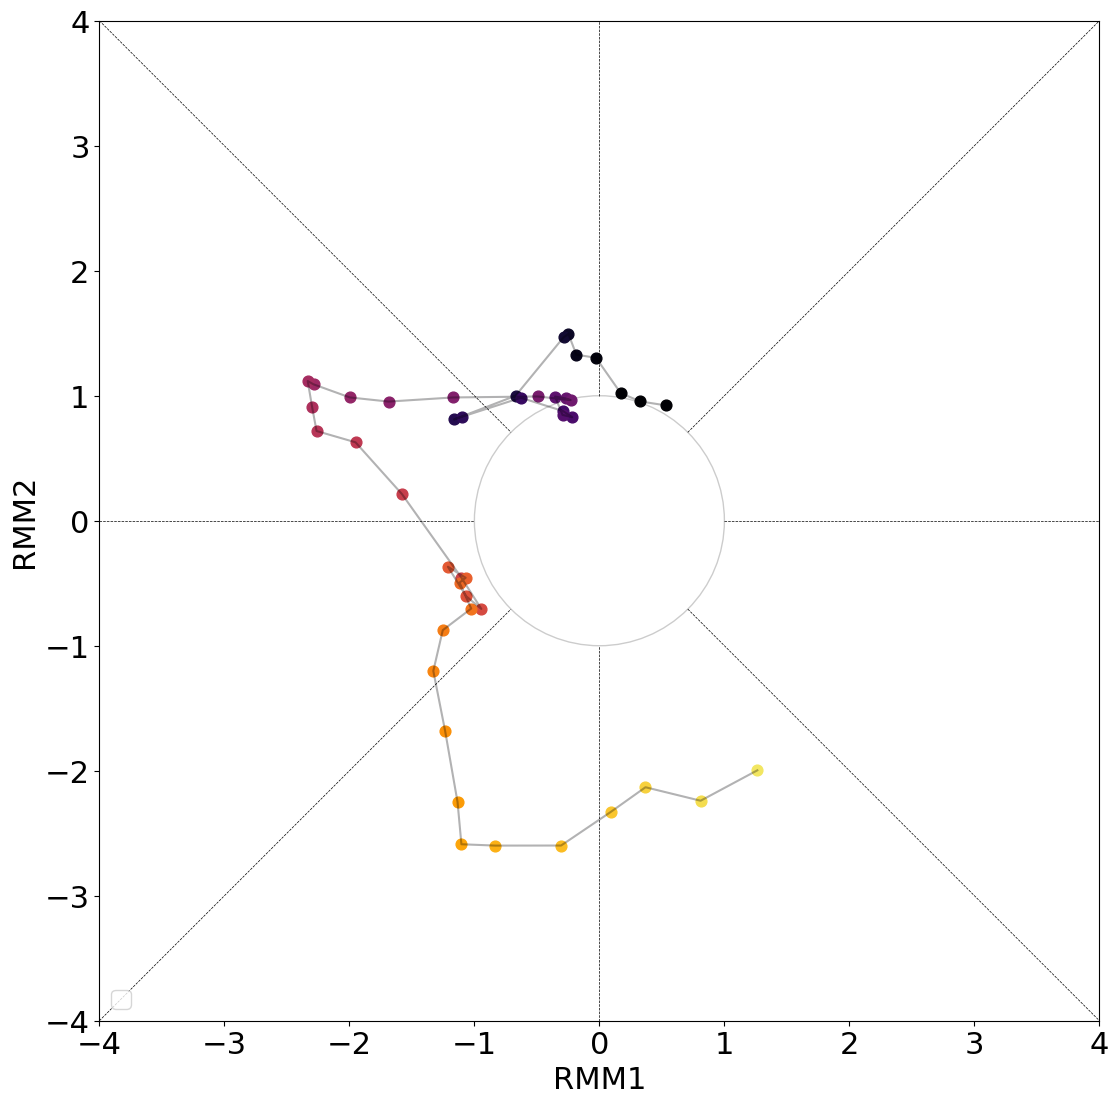

In [44]:
fig=plt.figure(figsize=(10, 10))

yert=79 #November: 79 is good. #Feb 74 is good
d_plot = 45

lcolor=['b','g','r','c','m','y']
lmarker=['-o','-v','-<','-s','-p','-D']
circ45len=np.sqrt(2)/2


ax1=fig.add_axes([0,0,1,1])
# pimp out the plot a little bit  
ax1.plot([circ45len,4],[circ45len,4],linewidth=0.5,linestyle='--',color='k')
ax1.plot([-4,-circ45len],[-4,-circ45len],linewidth=0.5,linestyle='--',color='k')
ax1.plot([-4,-circ45len],[4,circ45len],linewidth=0.5,linestyle='--',color='k')
ax1.plot([circ45len,4],[-circ45len,-4],linewidth=0.5,linestyle='--',color='k')
ax1.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
ax1.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
ax1.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
ax1.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')

axisrange=4
ax1.set_xlim([-axisrange,axisrange])
ax1.set_ylim([-axisrange,axisrange])
ax1.set_xlabel('RMM1',fontsize=22)
ax1.set_ylabel('RMM2',fontsize=22)

ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)

# circle in the center of the plot to denote weak index  
circle = plt.Circle((0, 0), radius=1.0,  fc='white', ec='k', alpha=0.2) #
ax1.add_patch(circle)


def cstm_rdbu_r(x):
    return plt.cm.inferno((np.clip(x,2,d_plot)-2)/d_plot)


compiled_forecast_RMM1=MJO_fobs2['RMM1_cera20c'].isel(time=slice(20,20+45)).values
compiled_forecast_RMM2=MJO_fobs2['RMM2_cera20c'].isel(time=slice(20,20+45)).values


for ee,day_scat in enumerate(range(d_plot)):
    ax1.scatter(compiled_forecast_RMM1[ee],compiled_forecast_RMM2[ee],color=cstm_rdbu_r(day_scat),alpha=1,s=60)
ax1.plot(compiled_forecast_RMM1,compiled_forecast_RMM2,color=cstm_rdbu_r(1),alpha=0.3)

ax1.legend(loc='lower left',fontsize='xx-large')
plt.show()
